In [14]:
#libraries and dataframe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import math
from scipy.stats import shapiro, ttest_ind, norm

file = r"..\data\clean\clean_df_all_with_dates_and_time.csv"
df_all = pd.read_csv(file)

## Completion rate

Hypothesis: Compare the completion rate between the Test group (new design) and the Control group (old design).

Objective: To check whether the difference is statistically significant.

Actions: Define null and alternative hypotheses, test with appropriate significance level, analyze p-value and other statistical measures.

Null hypothesis (H0): There is a significant difference in the completion rate between the Test group (new design) and the Control group (old design).

Alternative hypothesis (H1): There is no significant difference in the completion rate between the Test group (new design) and the Control group (old design).

In [13]:
# Create the crosstab for all process steps and variations
crosstab_all = pd.crosstab(df_all["process_step"], df_all["Variation"])

# Define the steps in order
steps_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Reindex the crosstab to ensure it follows the correct order
crosstab_all = crosstab_all.reindex(steps_order)
print(crosstab_all)

# Extract control and test counts from the crosstab
control_counts = crosstab_all['Control']
test_counts = crosstab_all['Test']

# Get the starting counts for control and test groups
control_start = control_counts.loc['start']
test_start = test_counts.loc['start']

print(f"\nControl Start (start): {control_start}")
print(f"Test Start (start): {test_start}")

# Calculate the completion percentages for control and test groups
control_percentages = (control_counts / control_start) * 100
test_percentages = (test_counts / test_start) * 100

# Round the percentages to 2 decimal places and convert to lists
control_percentages = control_percentages.round(2).tolist()
test_percentages = test_percentages.round(2).tolist()

print("\nControl (%):", control_percentages)
print("Test (%):", test_percentages)


Variation     Control   Test
process_step                
start           47589  56452
step_1          29657  38753
step_2          25877  30978
step_3          22787  25888
confirm         17498  25716

Control Start (start): 47589
Test Start (start): 56452

Control (%): [100.0, 62.32, 54.38, 47.88, 36.77]
Test (%): [100.0, 68.65, 54.87, 45.86, 45.55]


In [15]:
alpha = 0.05  # Significance level

# Calculate completion rates for control and test groups
control_completion_rate = round(control_percentages[-1])/100  # 36%
test_completion_rate = round(test_percentages[-1])/100  # 45%

# Get the sample sizes for control and test groups at 'confirm' step
control_sample_size = crosstab_all.loc['confirm', 'Test']  
test_sample_size = crosstab_all.at['confirm', 'Control'] 

# Calculate the number of completions for control and test groups
control_completions = int(control_completion_rate * control_sample_size)
test_completions = int(test_completion_rate * test_sample_size)
print(f"control: {control_completions}, test: {test_completions}")

# Calculate the number of failures for control and test groups
control_failures = control_sample_size - control_completions
test_failures = test_sample_size - test_completions

# Create data lists for control and test groups
control_data = [1] * control_completions + [0] * control_failures
test_data = [1] * test_completions + [0] * test_failures

# Perform t-test to compare the completion rates
t_stat, p_value_ttest = st.ttest_ind(control_data, test_data, equal_var=False, alternative="less")

t_stat, p_value_ttest

print(f"result stats: {t_stat:.2f}, result p_val: {p_value_ttest:.2f}")

# Interpret the results
if p_value_ttest > alpha:
    print("There is no difference in the completion rates between the Control and Test groups")
else:
    print("The completion rates between the Control and Test groups are different")


control: 9514, test: 8049
result stats: -18.67, result p_val: 0.00
The completion rates between the Control and Test groups are different


In [16]:
#to keep for me only
# Create the crosstab for all process steps and variations
crosstab_all = pd.crosstab(df_all["process_step"], df_all["Variation"])

# Extract the number of users who reached 'confirm' for Test group
confirm_test = crosstab_all.loc['confirm', 'Test']

# Extract the number of users who reached 'confirm' for Control group
confirm_control = crosstab_all.at['confirm', 'Control']





## Break-even completion rate

Hypothesis: The new design must increase the completion rate by at least 5% to be profitable.

Objective: Confirm that the observed improvement meets or exceeds this threshold.

Actions: Perform an analysis to verify whether the increase is significant enough to justify the costs.

Null hypothesis (H0): The increase in the completion rate of the Test group (new design) is less than 5% compared with the Control group (old design).

Alternative hypothesis (H1): The increase in the completion rate of the Test group (new design) is equal to or greater than 5% compared with the Control group (old design).

In [17]:
threshold_increase = 0.05  # 5% improvement
observed_increase = test_completion_rate - control_completion_rate

# Calculate the standard error of the difference in completion rates
se_diff = math.sqrt(
    (control_completion_rate * (1 - control_completion_rate)) / control_sample_size +
    (test_completion_rate * (1 - test_completion_rate)) / test_sample_size
)

# Calculate the z-statistic for the threshold
z_stat_threshold = (observed_increase - threshold_increase) / se_diff

# Calculate the p-value for the z-statistic
p_value_threshold = 1 - norm.cdf(z_stat_threshold)

z_stat_threshold, p_value_threshold

# Interpret the results
if p_value_threshold > threshold_increase:
    print("The improvement in the Test group's completion rate is less than 5%.")
else:
    print(f"The improvement in the Test group's completion rate is 5% or more.")


The improvement in the Test group's completion rate is 5% or more.


## Other hypotheses

Compare the average age of customers using the new and old processes.

Compare the length of service of customers using the new and old processes.

Null hypothesis (H0): The average age of customers using the new process is the same as that of customers using the old process.

Alternative hypothesis (H1): The average age of customers using the new process is different from that of customers using the old process.

Null hypothesis (H0): The average seniority of customers using the new process is the same as that of customers using the old process.

Alternative hypothesis (H1): The average seniority of customers using the new process is different from that of customers using the old process.

In [19]:
# Create the 'age_group' column
bins_quartiles = [0, 34.5, 50, 61, 100]  # Adjusted to include all ages
labels_quartiles = ['0-34', '35-50', '51-61', '62-100']

df_all['age_group'] = pd.cut(
    df_all['clnt_age'],
    bins=bins_quartiles,
    labels=labels_quartiles,
    right=True,
    include_lowest=True
)

# Verify the creation of 'age_group'
print("Columns of df:", df_all.columns.tolist())
print("\nDistribution of age groups:")
print(df_all['age_group'].value_counts())
print("\nNumber of NaN values in 'age_group':", df_all['age_group'].isnull().sum())

# Split into Control and Test groups
control_group = df_all[df_all['Variation'] == 'Control']
test_group = df_all[df_all['Variation'] == 'Test']


Columns of df: ['client_id', 'visitor_id', 'visit_id', 'process_step', 'Variation', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'date', 'time', 'age_group']

Distribution of age groups:
age_group
51-61     81536
0-34      81035
35-50     80387
62-100    78237
Name: count, dtype: int64

Number of NaN values in 'age_group': 0


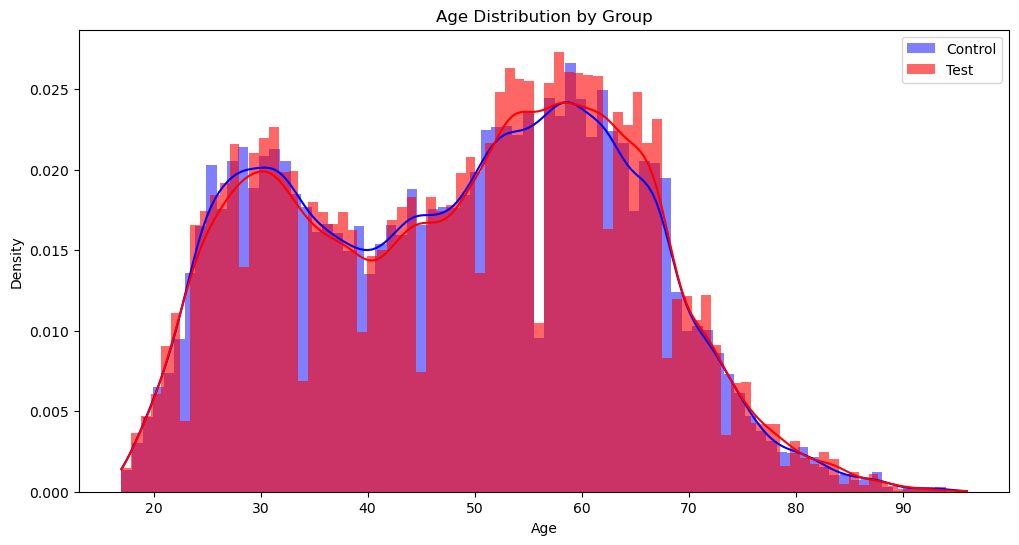

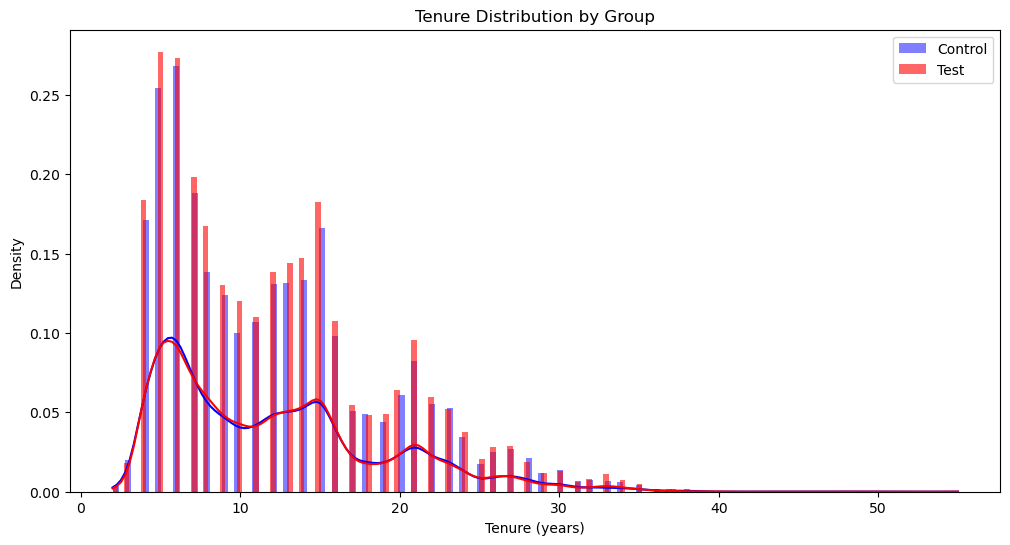

In [20]:
# Visualize Distributions

# Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(control_group['clnt_age'], color='blue', label='Control', kde=True, stat="density", linewidth=0)
sns.histplot(test_group['clnt_age'], color='red', label='Test', kde=True, stat="density", linewidth=0, alpha=0.6)
plt.title('Age Distribution by Group')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

# Tenure Distribution
plt.figure(figsize=(12, 6))
sns.histplot(control_group['clnt_tenure_yr'], color='blue', label='Control', kde=True, stat="density", linewidth=0)
sns.histplot(test_group['clnt_tenure_yr'], color='red', label='Test', kde=True, stat="density", linewidth=0, alpha=0.6)
plt.title('Tenure Distribution by Group')
plt.xlabel('Tenure (years)')
plt.ylabel('Density')
plt.legend()
plt.show()

### 5. Vérification des Conditions des Tests Statistiques

In [21]:
# a. Normality Test (Shapiro-Wilk)
def test_normality(data, group_name, variable):
    # If the data length is greater than 5000, take a sample of 5000
    if len(data) > 5000:
        data_sample = data.sample(5000, random_state=42)
    else:
        data_sample = data
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(data_sample)
    print(f'Shapiro-Wilk Test for {variable} in the {group_name} group: Statistic={stat:.4f}, p-value={p:.4f}')
    # Interpret the p-value
    if p > 0.05:
        print('The data appears to follow a normal distribution.\n')
    else:
        print('The data does not follow a normal distribution.\n')

# Normality test for age
test_normality(control_group['clnt_age'], 'Control', 'Age')
test_normality(test_group['clnt_age'], 'Test', 'Age')

# Normality test for tenure
test_normality(control_group['clnt_tenure_yr'], 'Control', 'Tenure')
test_normality(test_group['clnt_tenure_yr'], 'Test', 'Tenure')


Shapiro-Wilk Test for Age in the Control group: Statistic=0.9771, p-value=0.0000
The data does not follow a normal distribution.

Shapiro-Wilk Test for Age in the Test group: Statistic=0.9708, p-value=0.0000
The data does not follow a normal distribution.

Shapiro-Wilk Test for Tenure in the Control group: Statistic=0.9147, p-value=0.0000
The data does not follow a normal distribution.

Shapiro-Wilk Test for Tenure in the Test group: Statistic=0.9165, p-value=0.0000
The data does not follow a normal distribution.



In [23]:
# Welch's t-test for age (does not assume equal variances)
t_stat_age_welch, p_val_age_welch = ttest_ind(control_group['clnt_age'], test_group['clnt_age'], equal_var=False)
print(f'Welch\'s t-test for age: t-statistic={t_stat_age_welch:.4f}, p-value={p_val_age_welch:.4f}')
if p_val_age_welch > 0.05:
    print('No significant difference in mean age between Control and Test groups (Welch).\n')
else:
    print('Significant difference in mean age between Control and Test groups (Welch).\n')

# Welch's t-test for tenure (does not assume equal variances)
t_stat_tenure_welch, p_val_tenure_welch = ttest_ind(control_group['clnt_tenure_yr'], test_group['clnt_tenure_yr'], equal_var=False)
print(f'Welch\'s t-test for tenure: t-statistic={t_stat_tenure_welch:.4f}, p-value={p_val_tenure_welch:.4f}')
if p_val_tenure_welch > 0.05:
    print('No significant difference in mean tenure between Control and Test groups (Welch).\n')
else:
    print('Significant difference in mean tenure between Control and Test groups (Welch).\n')


Welch's t-test for age: t-statistic=-7.9284, p-value=0.0000
Significant difference in mean age between Control and Test groups (Welch).

Welch's t-test for tenure: t-statistic=-0.3197, p-value=0.7492
No significant difference in mean tenure between Control and Test groups (Welch).

